## Preambule

In [1]:
# General packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import xarray as xr
import json

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors

## Read

In [2]:
path_main = Path("K:/Code/EffortSharing/")
path_data = Path("K:/Data/Data_EffortSharing/DataUpdate_ongoing/")
path_figs = path_main / "Figures" / "NZreport"

In [3]:
xr_dataread = xr.open_dataset(path_data / "xr_dataread.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)

In [4]:
settings_default =  {'Temperature': 1.6,
                   'Risk': 0.5,
                   'NegEmis': 0.5,
                   'NonCO2red': 0.5,
                   'Timing': "Immediate",
                   'Convergence_year': 2050,
                   'Scenario': 'SSP2',
                   'Discount_factor': 0,
                   'Historical_startyear': 1950,}
settings_default_global = {'Temperature': 1.6,
                   'Risk': 0.5,
                   'NegEmis': 0.5,
                   'NonCO2red': 0.5,
                   'Timing': "Immediate"}

In [19]:
xr_allocs = []
for cty in ['EU', 'RWA', 'IND', 'USA', 'BRA', 'EARTH']:#list(all_countries_iso)+['EU']+['EARTH']:
    xr_allocs.append(xr.open_dataset(path_data / "Allocations_CO2_excl" / ("xr_alloc_"+cty+".nc")).expand_dims({'Region':[cty]}).sel(**settings_default)[['GF', 'ECPC', 'PCC', 'AP', 'PC']])
xr_allocs = xr.merge(xr_allocs)

# xr_allocs_incl = []
# for cty in ['EU', 'USA', 'IND', 'CHN', 'JPN', 'AUS', 'BRA', 'RUS', 'ZAF']:
#     xr_allocs_incl.append(xr.open_dataset(path_data / "Allocations_CO2_incl" / ("xr_alloc_"+cty+".nc")).expand_dims({'Region':[cty]})[['GF', 'ECPC', 'PCC', 'AP', 'PC']].sel(Temperature=1.6, Risk=0.5, NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Scenario='SSP2'))
# xr_allocs_incl = xr.merge(xr_allocs_incl)

In [6]:
# xr_allocs = []
# for cty in ['EU', 'USA', 'BRA', 'EARTH']:#list(all_countries_iso)+['EU']+['EARTH']:
#     xr_allocs.append(xr.open_dataset(path_data / "Allocations" / ("xr_alloc_"+cty+".nc")).expand_dims({'Region':[cty]}).sel(**settings_default)[['GF', 'ECPC', 'PCC', 'AP', 'PC']])
# xr_allocs = xr.merge(xr_allocs)

## Plot

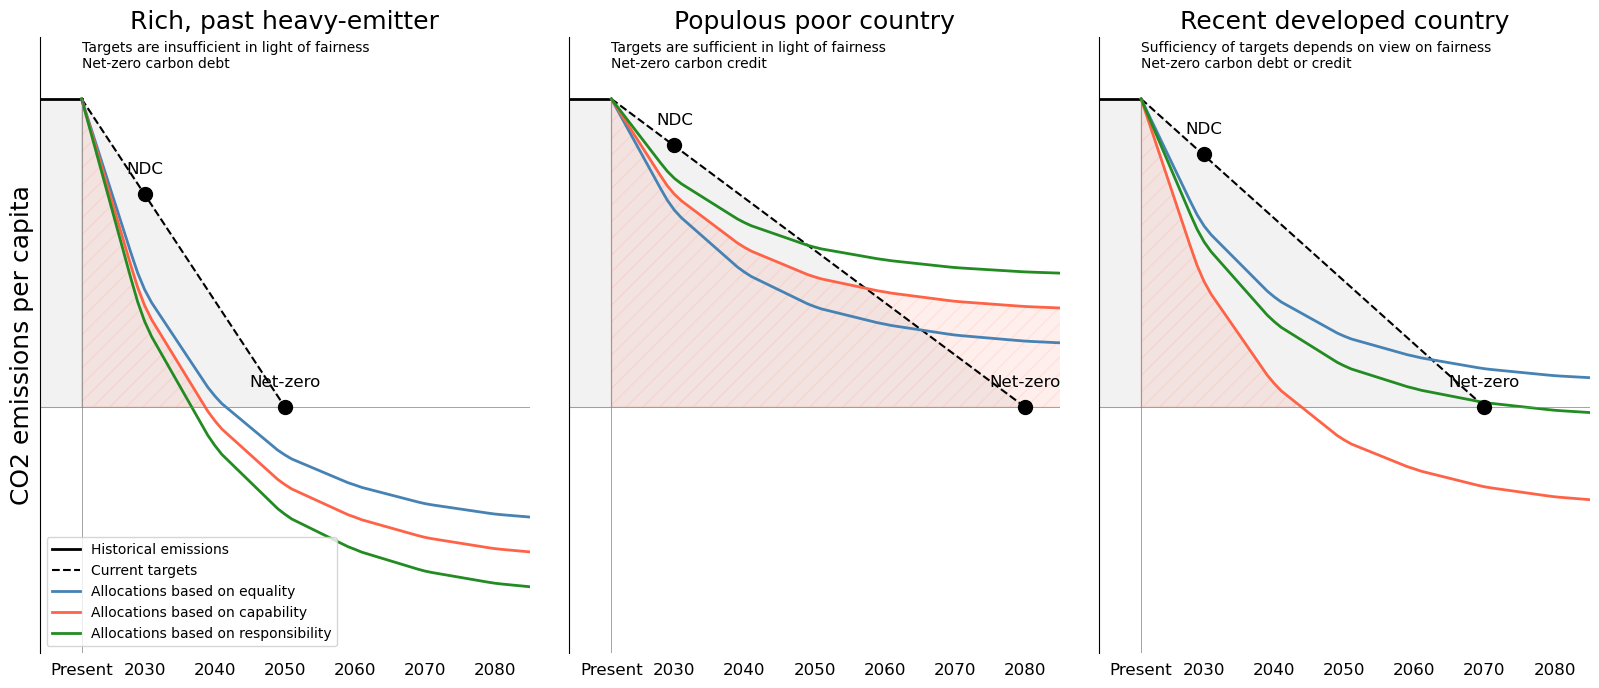

In [144]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
# set horizontal spacing
fig.subplots_adjust(wspace=0.08)
ax1.set_title("Rich, past heavy-emitter", fontsize=18)
ax2.set_title("Populous poor country", fontsize=18)
ax3.set_title("Recently developed country", fontsize=18)

# Historical emissions
for ax_i, ax in enumerate([ax1, ax2, ax3]):
    cty = 'USA'
    #pop = xr_dataread.Population.sel(Region=cty, Scenario='SSP2')
    curlev =  xr_dataread.CO2_hist_excl.sel(Region=cty).sel(Time=2021)
    ax.plot([2015, 2021], [1, 1], lw=2, label='Historical emissions', c='black')
    ax.plot([2021, [2050, 2080, 2070][ax_i]], [1, 0], '--', label='Current targets', c='black')
    ax.plot(xr_allocs.Time, 2*xr_allocs.sel(Region=cty)['GF']/curlev+(1-xr_allocs.sel(Region=cty)['GF']/curlev) * [0.8, 1.3, 1.2][ax_i]-1, lw=2, label='Allocations based on equality', c='steelblue')
    ax.plot(xr_allocs.Time, 2*xr_allocs.sel(Region=cty)['GF']/curlev+(1-xr_allocs.sel(Region=cty)['GF']/curlev) * [0.7, 1.4, 0.85][ax_i]-1, lw=2, label='Allocations based on capability', c='tomato')
    ax.plot(xr_allocs.Time, 2*xr_allocs.sel(Region=cty)['GF']/curlev+(1-xr_allocs.sel(Region=cty)['GF']/curlev) * [0.6, 1.5, 1.1][ax_i]-1, lw=2, label='Allocations based on responsibility', c='forestgreen')

    # fill area up to 2021
    ax.fill_between(xr_dataread.Time.sel(Time=np.arange(1950, 2022)), 0, 1, color='grey', alpha=0.1)
    ax.fill_between([2021, [2050, 2080, 2070][ax_i]], [0, 0], [1, 0], color='grey', alpha=0.1)
    y = 2*xr_allocs.sel(Region=cty)['GF']/curlev+(1-xr_allocs.sel(Region=cty)['GF']/curlev) * [0.7, 1.4, 0.85][ax_i]-1
    ax.fill_between(xr_allocs.Time, [0]*len(y), y, where=y>=0, color='tomato', alpha=0.1, hatch='//')

    # ax.plot(xr_allocs.Time, xr_allocs.sel(Region=cty)['PCC']/curlev, label='Allocations based on equality', c='tomato')
    # ax.plot(xr_allocs.Time, xr_allocs.sel(Region=cty)['ECPC']/curlev, label='Allocations based on responsibility', c='forestgreen')
    # ax.plot(xr_allocs.Time, xr_allocs.sel(Region=cty)['AP']/curlev, label='Allocations based on capability', c='goldenrod')
    ax.set_xlim([2015, 2085])
    ax.set_ylim([-0.8, 1.2])
    ax.plot([2015, 2100], [0, 0], 'grey', lw=0.5)
    ax.plot([2021, 2021], [-1e9, 1], 'grey', lw=0.5)
    ax.plot([2030, [2050, 2080, 2070][ax_i]], [[0.69, 0.85, 0.82][ax_i], 0], 'ok', ms=10)
    ax.text(2030, [0.69, 0.85, 0.82][ax_i], 'NDC\n', fontsize=12, ha='center', va='bottom')
    ax.text([2050, 2080, 2070][ax_i], 0, 'Net-zero\n', fontsize=12, ha='center', va='bottom')

    ax.text(2021, 1.1, ["Targets are insufficient in light of fairness\nNet-zero carbon debt",
                        'Targets are sufficient in light of fairness\nNet-zero carbon credit',
                        'Sufficiency of targets depends on view on fairness\nNet-zero carbon debt or credit'][ax_i])
ax1.set_ylabel("CO2 emissions per capita", fontsize=18)

# Turn frame axis off
for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_tick_params(width=0)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.xaxis.set_tick_params(width=0)
    ax.set_xticks([2021, 2030, 2040, 2050, 2060, 2070, 2080])
    ax.set_xticklabels(['Present', '2030', '2040', '2050', '2060', '2070', '2080'], fontsize=12)
    ax.set_yticks([])

ax1.legend(loc='lower left')

Text(0.5, 1.0, 'EARTH')

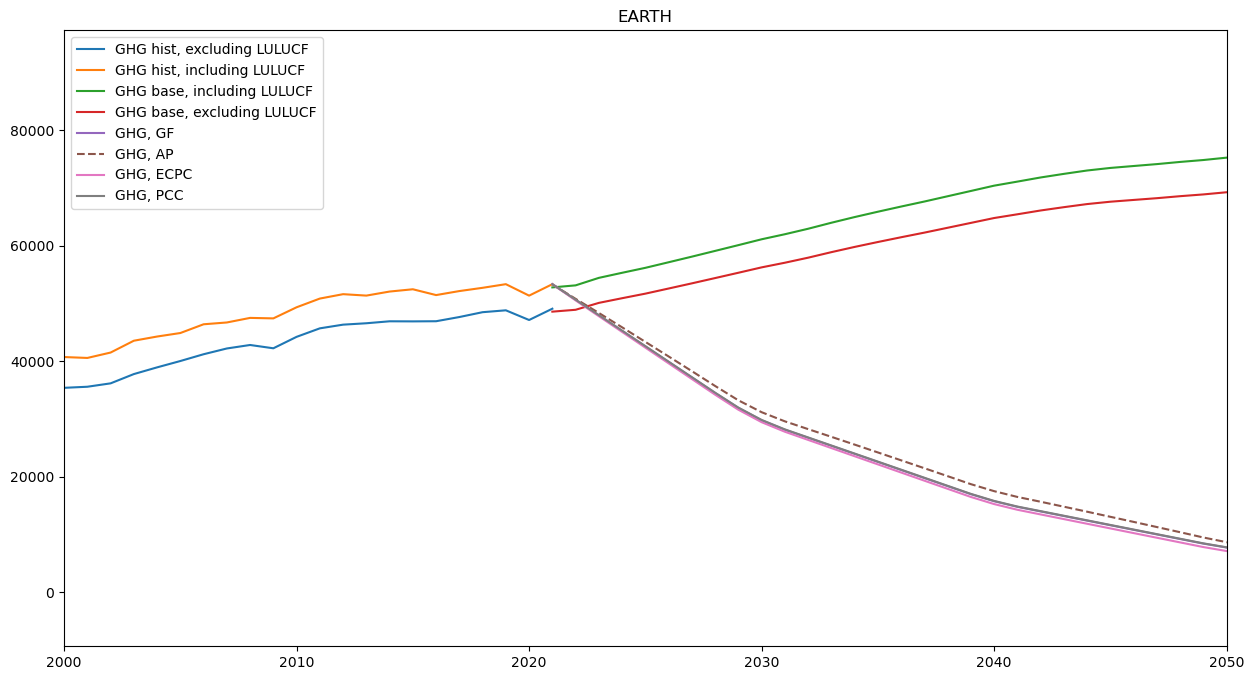

In [9]:
reg = 'EARTH'

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(xr_dataread.Time, xr_dataread.GHG_hist_excl.sel(Region=reg), label='GHG hist, excluding LULUCF')
plt.plot(xr_dataread.Time, xr_dataread.GHG_hist.sel(Region=reg), label='GHG hist, including LULUCF')
plt.plot(xr_dataread.Time.sel(Time=np.arange(2021, 2101)), xr_dataread.GHG_base.sel(Region=reg, Scenario='SSP2', Time=np.arange(2021, 2101)), label='GHG base, including LULUCF')
plt.plot(xr_dataread.Time.sel(Time=np.arange(2021, 2101)), xr_dataread.GHG_base_excl.sel(Region=reg, Scenario='SSP2', Time=np.arange(2021, 2101)), label='GHG base, excluding LULUCF')


plt.plot(xr_allocs.Time, xr_allocs.sel(Region=reg).GF, label='GHG, GF')
plt.plot(xr_allocs.Time, xr_allocs.sel(Region=reg).AP, '--', label='GHG, AP')
plt.plot(xr_allocs.Time, xr_allocs.sel(Region=reg).ECPC, label='GHG, ECPC')
plt.plot(xr_allocs.Time, xr_allocs.sel(Region=reg).PCC, label='GHG, PCC')

plt.legend()
plt.xlim([2000, 2050])
plt.title(reg)

Text(0.5, 1.0, 'EARTH')

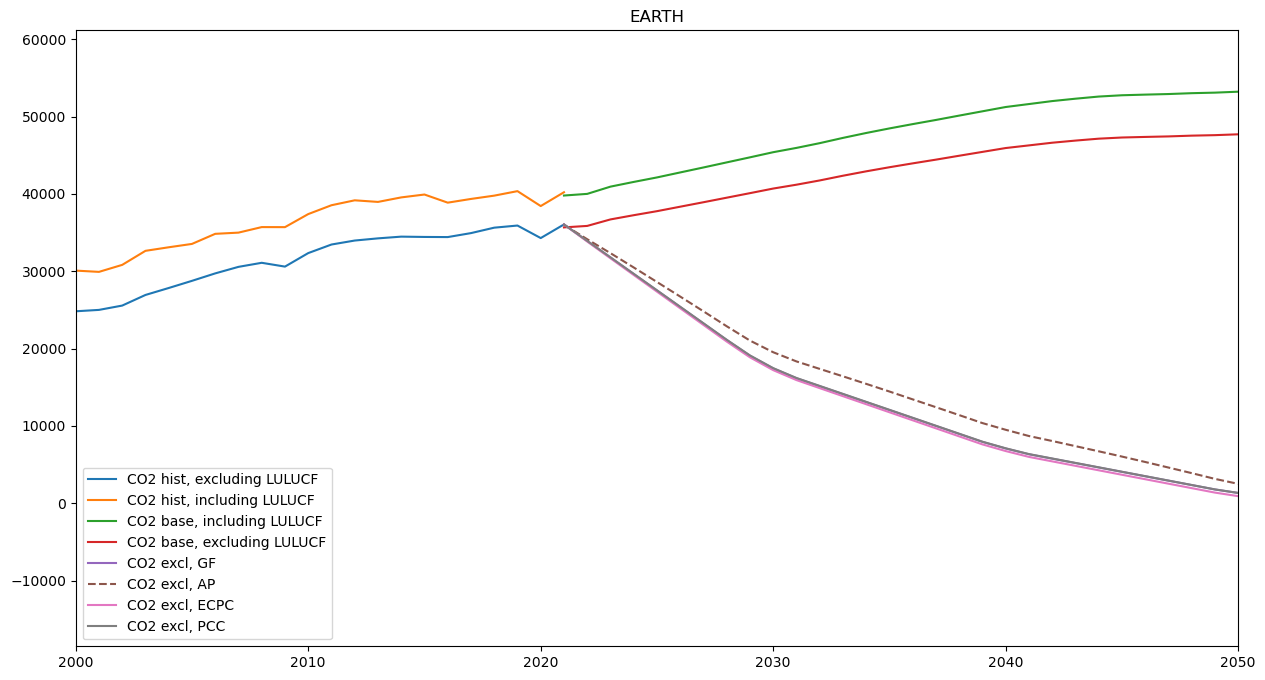

In [10]:
reg = 'EARTH'

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(xr_dataread.Time, xr_dataread.CO2_hist_excl.sel(Region=reg), label='CO2 hist, excluding LULUCF')
plt.plot(xr_dataread.Time, xr_dataread.CO2_hist.sel(Region=reg), label='CO2 hist, including LULUCF')
plt.plot(xr_dataread.Time.sel(Time=np.arange(2021, 2101)), xr_dataread.CO2_base.sel(Region=reg, Scenario='SSP2', Time=np.arange(2021, 2101)), label='CO2 base, including LULUCF')
plt.plot(xr_dataread.Time.sel(Time=np.arange(2021, 2101)), xr_dataread.CO2_base_excl.sel(Region=reg, Scenario='SSP2', Time=np.arange(2021, 2101)), label='CO2 base, excluding LULUCF')


plt.plot(xr_allocs.Time, xr_allocs.sel(Region=reg).GF, label='CO2 excl, GF')
plt.plot(xr_allocs.Time, xr_allocs.sel(Region=reg).AP, '--', label='CO2 excl, AP')
plt.plot(xr_allocs.Time, xr_allocs.sel(Region=reg).ECPC, label='CO2 excl, ECPC')
plt.plot(xr_allocs.Time, xr_allocs.sel(Region=reg).PCC, label='CO2 excl, PCC')

plt.legend()
plt.xlim([2000, 2050])
plt.title(reg)

In [106]:
reds_2040 = -(xr_allocs.sel(Time=2040) - xr_dataread.sel(Time=2015).CO2_hist_excl) / xr_dataread.sel(Time=2015).CO2_hist_excl
reds_2030 = -(xr_allocs.sel(Time=2030) - xr_dataread.sel(Time=2015).CO2_hist_excl) / xr_dataread.sel(Time=2015).CO2_hist_excl

In [107]:
path_ctygroups = "X:/user/dekkerm/Data/" + "UNFCCC_Parties_Groups_noeu.xlsx"
df = pd.read_excel(path_ctygroups, sheet_name = "Country groups")
countries_iso = np.array(df["Country ISO Code"])
countries_name = np.array(df["Name"])
countries_iso = np.array(df["Country ISO Code"])
group_eu = countries_iso[np.array(df["EU"]) == 1]

## Plot

In [10]:
fig = make_subplots(rows=3, cols=2,
                    specs=[[{'type': 'choropleth'}, {}],
                           [{'type': 'choropleth'}, {}],
                           [{'type': 'choropleth'}, {}]],
                    horizontal_spacing = 0.05, vertical_spacing=0.05, shared_xaxes=True)
for i in range(3):
    dath = [reds_2040.PCC, reds_2040.AP, reds_2040.ECPC][i]
    dat = np.array(dath)
    # if i>2:
    #     dat[dat < 0] = 0
    #scale = ['RdBu_r', 'RdBu_r', 'PuOr_r', 'PuOr_r'][i]
    #scale = ['RdYlBu_r', 'RdYlBu_r', 'Earth_r', 'Earth_r'][i]
    scale = 'RdYlBu_r'
    dc = [#dict(orientation='h', x=0.25, y=0.52, xanchor='left', yanchor='bottom', title='NDC deviation from emission allocation in 2030', tickvals=[-1, -0.5, 0, 0.5, 1],
                        #ticktext=['100%<br>NDC sufficient <', '50%', '0%', '50%', '100%<br>> NDC insufficient'],
                        # tickfont=dict(size=14),
                        # len=0.5, lenmode='fraction', thickness=20, thicknessmode='pixels', titlefont=dict(size=14)),
         dict(x=0.0, y=0.5, xanchor='left', title='Emissions reduction<br>in 2040<br>w.r.t. 2015', tickvals=[0, 0.5, 1], ticktext=['0%', '50%', '100%']), dict(), dict()][i]
    
    # Grey out nans
    wh = np.where(np.isnan(dat))[0]
    fig.add_trace(go.Choropleth(
            locations=list(np.array(dath.Region)[wh])+['GRL'],
            z = [0.5]*(len(dat[wh])+1),
            locationmode = 'ISO-3',
            colorscale ='Greys',
            zmax = 1,
            zmin = 0,
            hovertemplate  = '%{text}',
            name="",
            marker_line_color='black', 
            marker_line_width=0.5,
            showscale=False,
        ), [1, 2, 3][i], [1, 1, 1][i])
    
    fig.add_trace(go.Choropleth(
            locations=np.array((dath).Region),
            z = dat,
            locationmode = 'ISO-3',
            colorscale = scale,
            zmax = 1,
            zmin = 0,
            text = [str(r)+": "+str(np.round(100*dat[r_i], 1))+" %" for r_i, r in enumerate(np.array((dath).Region))],
            hovertemplate  = '%{text}',
            name="",
            colorbar=dc,
            marker_line_color='black', 
            marker_line_width=0.5,
            showscale=[True, False, False][i],
        ), [1, 2, 3][i], [1, 1, 1][i])
    
    # EU
    fig.add_trace(go.Choropleth(
            locations=group_eu,
            z = [dat[np.where(np.array((dath).Region) == 'EU')[0][0]]]*len(group_eu),
            locationmode = 'ISO-3',
            colorscale =scale,
            zmax = 1,
            zmin = 0,
            #text = [str(r)+": "+str(np.round(100*dat[r_i], 1))+" %" for r_i, r in enumerate(group_eu)],
            hovertemplate  = '%{text}',
            name="",
            marker_line_color='black', 
            marker_line_width=0.5,
            showscale=False,
        ), [1, 2, 3][i], [1, 1, 1][i])

fs=20
fig['layout'].update(
    annotations=[dict(x=0.05, y=1.04, text='<b>(a) Allocation based on population</b>', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs)),
                 dict(x=0.05, y=0.71, text='<b>(b) Allocation based on GDP per capita', xref='paper', yref='paper', xanchor='left', showarrow=False, font=dict(color='black', size=fs)),
                 dict(x=0.05, y=0.35, text='<b>(c) Allocation based on historical responsibility', xref='paper', yref='paper', xanchor='left', showarrow=False, font=dict(color='black', size=fs)),
])

fig.update_geos(visible=False,
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                resolution=110,
                showcoastlines=False,)
fig.update_traces(colorbar=dict(
    title=dict(
        side="bottom"
    )
))
fig.update_geos(landcolor="grey")

# Line plots
for i in range(3):
    fig.add_trace(go.Scatter(x=xr_dataread.Time,
                            y=xr_dataread.CO2_hist_excl.sel(Region='EARTH') / xr_dataread.CO2_hist_excl.sel(Region='EARTH', Time=2021),
                            name = 'World',
                            line={'color': 'black', 'width': 2}, mode='lines',
                            legend='legend2',
                            showlegend=False), row=1+i, col=2)
    fig.add_trace(go.Scatter(x=xr_dataread.Time,
                            y=xr_dataread.sel(**settings_default_global).CO2_globe_excl / xr_dataread.CO2_hist_excl.sel(Region='EARTH', Time=2021),
                            name = 'World',
                            line={'color': 'black', 'width': 2, 'dash': 'dash'}, mode='lines',
                            legend='legend2',
                            showlegend=False), row=1+i, col=2)
    for reg_i, reg in enumerate([ 'USA', 'CHN', 'IND', 'BRA']):
        col = ['steelblue', 'tomato', 'goldenrod', 'forestgreen'][reg_i]
        y = xr_allocs.sel(Region=reg)[['PCC', 'AP', 'ECPC'][i]] / xr_dataread.CO2_hist_excl.sel(Region=reg, Time=2021)
        y2 = y - y[0]+1
        fig.add_trace(go.Scatter(x=xr_allocs.Time,
                                y=y2,
                                name = reg,
                                line={'color': col, 'width': 2}, mode='lines',
                                legend='legend2',
                                showlegend=False), row=1+i, col=2)
    # Add horizontal line at y=0
    fig.add_shape(x0=2020, x1=2040, y0=0, y1=0, line=dict(color='black', width=2), row=1+i, col=2)
    fig.update_yaxes(title_text="Emissions compared to 2015", row=1+i, col=2, range=[-0.5, 1.2])
    fig.update_xaxes(range=[2020, 2040], row=1+i, col=2)

args = dict(xref="paper", yref="paper", type='line')

# fig.add_shape(x0=0.08, y0=0.20, x1=0.12, y1=0.35, **args, line=dict(color='black', width=2))
# fig.add_shape(x0=0.75, y0=0.29, x1=0.85, y1=0.40, **args, line=dict(color='black', width=2))
# fig.add_shape(x0=0.90, y0=0.12, x1=0.93, y1=0.18, **args, line=dict(color='black', width=2))

# fig.add_shape(x0=0.08, y0=0.63, x1=0.12, y1=0.85, **args, line=dict(color='black', width=2))
# fig.add_shape(x0=0.87, y0=0.62, x1=0.85, y1=0.90, **args, line=dict(color='black', width=2))

# fig.add_shape(x0=0., y0=1.03, x1=0.495, y1=1.03, **args, line=dict(color='black', width=2))
# fig.add_shape(x0=0., y0=1.01, x1=0., y1=1.03, **args, line=dict(color='black', width=2))
# fig.add_shape(x0=0.495, y0=1.01, x1=0.495, y1=1.03, **args, line=dict(color='black', width=2))

# fig.add_shape(x0=0.505, y0=1.03, x1=1, y1=1.03, **args, line=dict(color='black', width=2))
# fig.add_shape(x0=0.505, y0=1.01, x1=0.505, y1=1.03, **args, line=dict(color='black', width=2))
# fig.add_shape(x0=1, y0=1.01, x1=1, y1=1.03, **args, line=dict(color='black', width=2))

fig.update_layout(height=1300, width=1600, template='simple_white')
#fig.write_image("K:/Code/EffortSharing/Figures/Paper_FairShares/Figure_4.png", scale=5)
fig.show()

NameError: name 'reds_2040' is not defined